In [7]:
import pandas as pd
import numpy as np

from random import randrange

from sklearn.metrics import confusion_matrix, classification_report

# Data Training 

In [8]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
df = pd.read_csv("/Volumes/Programming/coding/Artificial-Neural-Network/Artificial-Neural-Network/Single-Layer-Perceptron/data/train_data_cl.csv", header=None, names=list(range(13)))
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NaN
1,1,0,3,Braund,Mr. Owen Harris,male,22,1,0,A/5 21171,7.25,NaN,S
2,2,1,1,Cumings,Mrs. John Bradley (Florence Briggs Thayer),female,38,1,0,PC 17599,712.833,C85,C
3,3,1,3,Heikkinen,Miss. Laina,female,26,0,0,STON/O2. 3101282,7.925,NaN,S
4,4,1,1,Futrelle,Mrs. Jacques Heath (Lily May Peel),female,35,1,0,113803,53.1,C123,S


## Data Preprocessing

In [9]:
### Benerin column
col_name = df.iloc[0,:12].values
col_name = np.insert(col_name, 4, "FirstName")

df.columns = col_name
df = df.drop(0).reset_index(drop=True)

df.head()
### Merge Name dan FirstName
df["Name"] = df["FirstName"] + " " + df["Name"]
df = df.drop("FirstName", axis=1)
df
### Perbaikan data yang tidak sesuai

print(df['Sex'].unique().tolist())
true_sex_val = ['male', 'female']
count = 0
for val in df["Sex"].values:
    if val not in true_sex_val:
        df.loc[count, 'Sex'] = np.random.choice(true_sex_val)
    count += 1
print(df['Sex'].unique().tolist())

count = 0
for val in df['Fare'].values:
    try:
        float(val)
    except ValueError:
        df.loc[count, 'Fare'] = 0
    count += 1

count = 0
for val in df['Parch'].values:
    if len(val) > 1:
        df.loc[count, 'Parch'] = 0
    count += 1

['male', 'female', '15', '27', '9', '36.5', '16', '40', '45', '24', '18', '20.5', '8', '26', '3', '1', '19', '21', '36', '22', '48', '49', '35', '39', '6']
['male', 'female']


In [10]:
### Encode
lbenc = LabelEncoder()

for i in df.columns.values:
    if df[i].dtypes == 'string':
        df[i] = lbenc.fit_transform(df[i])

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr. Owen Harris Braund,male,22,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cu...,female,38,1,0,PC 17599,712.833,C85,C
2,3,1,3,Miss. Laina Heikkinen,female,26,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35,1,0,113803,53.1,C123,S
4,5,0,3,Mr. William Henry Allen,male,35,0,0,373450,8.05,NaN,S


In [11]:
### Change Data Type
df.info()
df = df.astype({'PassengerId': 'int64', 'Survived': 'int64', 'Pclass': 'int64', 'SibSp': 'int64', 'Parch': 'int64'})
df = df.astype({'Name': 'string', 'Sex': 'string', 'Ticket': 'string', 'Cabin': 'string', 'Embarked': 'string'})
df = df.astype({'Age': 'float64', 'Fare': 'float64'})
df.info()
### Menghilangkan Column yang tidak dipakai
del df['Name']
del df['Ticket']
del df['Cabin']
### Cek & Replace Missing Value
missing = pd.DataFrame({
    'total' : df.isnull().sum(),
    'percent' : df.isnull().sum()/df.shape[0] * 100})

missing
df['Embarked'] = df['Embarked'].fillna(value=np.random.choice(df['Embarked'].unique().tolist()))
df['Fare'] = df['Fare'].fillna(value=0)
df.isna().sum()
clean_data = df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  712 non-null    object
 1   Survived     712 non-null    object
 2   Pclass       712 non-null    object
 3   Name         712 non-null    object
 4   Sex          712 non-null    object
 5   Age          712 non-null    object
 6   SibSp        712 non-null    object
 7   Parch        712 non-null    object
 8   Ticket       712 non-null    object
 9   Fare         685 non-null    object
 10  Cabin        210 non-null    object
 11  Embarked     677 non-null    object
dtypes: object(12)
memory usage: 66.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   P

In [12]:
## Encode
lbenc = LabelEncoder()

for i in df.columns.values:
    if df[i].dtypes == 'string':
        df[i] = lbenc.fit_transform(df[i])

df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.250,2
1,2,1,1,0,38.0,1,0,712.833,0
2,3,1,3,0,26.0,0,0,7.925,2
3,4,1,1,0,35.0,1,0,53.100,2
4,5,0,3,1,35.0,0,0,8.050,2


In [13]:
### Split Feature and Label
train = df.copy()
x_train = train.iloc[:, 2:].values
y_train = df.iloc[:, 1].values
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.250,2
1,2,1,1,0,38.0,1,0,712.833,0
2,3,1,3,0,26.0,0,0,7.925,2
3,4,1,1,0,35.0,1,0,53.100,2
4,5,0,3,1,35.0,0,0,8.050,2
...,...,...,...,...,...,...,...,...,...
707,886,0,3,0,39.0,0,5,29.125,1
708,887,0,2,1,27.0,0,0,13.000,2
709,888,1,1,0,19.0,0,0,30.000,2
710,890,1,1,1,26.0,0,0,30.000,0


In [14]:
### Normalisasi
feature = x_train.copy()
label = y_train.copy()
label = label.reshape(-1,1)
passengerId = train.iloc[:, 0].values.reshape(-1,1)
col = train.columns.values.tolist()
col.pop(1)
col.append("Survived")

mnmx = MinMaxScaler()
feature = mnmx.fit_transform(feature)

data = np.concatenate((passengerId, feature), axis=1)
dataLabel = np.concatenate((data, label), axis=1)
normalize_data_train = pd.DataFrame(dataLabel, columns=col)

normalize_data_train.drop('PassengerId', axis=1, inplace=True)
normalize_data_train = normalize_data_train.astype({"Survived": "int64"})

X_train_normalized = normalize_data_train.iloc[:, :-1].values
y_train = normalize_data_train.iloc[:, -1].values 

normalize_data_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1.0,1.0,0.2750,0.2,0.000000,0.007960,1.0,0
1,0.0,0.0,0.4750,0.2,0.000000,0.782652,0.0,1
2,1.0,0.0,0.3250,0.0,0.000000,0.008701,1.0,1
3,0.0,0.0,0.4375,0.2,0.000000,0.058301,1.0,1
4,1.0,1.0,0.4375,0.0,0.000000,0.008838,1.0,0
...,...,...,...,...,...,...,...,...
707,1.0,0.0,0.4875,0.0,0.833333,0.031978,0.5,0
708,0.5,1.0,0.3375,0.0,0.000000,0.014273,1.0,0
709,0.0,0.0,0.2375,0.0,0.000000,0.032938,1.0,1
710,0.0,1.0,0.3250,0.0,0.000000,0.032938,0.0,1


# Data Testing

In [15]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

dt = pd.read_csv(
    "/Volumes/Programming/coding/Artificial-Neural-Network/Artificial-Neural-Network/Single-Layer-Perceptron/data/test_data_cl.csv",
    header=None,
    names=list(range(12)),
)

gdt = pd.read_csv(
    "/Volumes/Programming/coding/Artificial-Neural-Network/Artificial-Neural-Network/Single-Layer-Perceptron/data/test_data_GroundTruth_cl.csv"
)
dt = dt.head(331)
dt

col_name = dt.iloc[0, :11].values
col_name = np.insert(col_name, 3, "FirstName")

dt.columns = col_name
dt = dt.drop(0).reset_index(drop=True)
dt

dt["Name"] = dt["FirstName"] + " " + dt["Name"]
dt = dt.drop("FirstName", axis=1)
dt

print(dt["Sex"].unique().tolist())
true_sex_val = ["male", "female"]
count = 0
for val in dt["Sex"].values:
    if val not in true_sex_val:
        dt.loc[count, "Sex"] = np.random.choice(true_sex_val)
    count += 1
print(dt["Sex"].unique().tolist())

count = 0
for val in dt["Fare"].values:
    try:
        float(val)
    except ValueError:
        dt.loc[count, "Fare"] = 0
    count += 1

count = 0
for val in dt["Parch"].values:
    if len(val) > 1:
        dt.loc[count, "Parch"] = 0
    count += 1

dt.info()

dt = dt.astype(
    {"PassengerId": "int64", "Pclass": "int64", "SibSp": "int64", "Parch": "int64"}
)
dt = dt.astype(
    {
        "Name": "string",
        "Sex": "string",
        "Ticket": "string",
        "Cabin": "string",
        "Embarked": "string",
    }
)
dt = dt.astype({"Age": "float64", "Fare": "float64"})
dt.info()

del dt["Name"]
del dt["Ticket"]
del dt["Cabin"]

missing = pd.DataFrame(
    {"total": dt.isnull().sum(), "percent": dt.isnull().sum() / dt.shape[0] * 100}
)

missing

dt["Embarked"] = dt["Embarked"].fillna(
    value=np.random.choice(dt["Embarked"].unique().tolist())
)
dt["Fare"] = dt["Fare"].fillna(value=0)
dt.isna().sum()

['male', 'female', '45', '18.5', '36', '20', '16', '42', '29', '30', '46', '19', '0.17', '22', '21']
['male', 'female']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  330 non-null    object
 1   Pclass       330 non-null    object
 2   Name         330 non-null    object
 3   Sex          330 non-null    object
 4   Age          330 non-null    object
 5   SibSp        330 non-null    object
 6   Parch        330 non-null    object
 7   Ticket       330 non-null    object
 8   Fare         317 non-null    object
 9   Cabin        100 non-null    object
 10  Embarked     316 non-null    object
dtypes: object(11)
memory usage: 28.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passen

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [16]:
lbenc = LabelEncoder()

for col in dt.columns.values:
    if dt[col].dtype == "string":
        dt[col] = lbenc.fit_transform(dt[col])

dt.head()

merged_test_data = pd.merge(dt, gdt, on="PassengerId")
merged_test_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,892,3,1,34.5,0,0,78.292,1,0
1,893,3,0,47.0,1,0,7.000,2,1
2,894,2,1,62.0,0,0,96.875,1,0
3,895,3,1,27.0,0,0,86.625,2,0
4,896,3,0,22.0,1,1,122.875,2,1
...,...,...,...,...,...,...,...,...,...
325,1299,1,1,50.0,1,1,211.500,0,0
326,1301,3,0,3.0,1,1,13.775,2,1
327,1303,1,0,37.0,1,0,90.000,1,1
328,1304,3,0,28.0,0,0,7.775,2,1


In [17]:
test = merged_test_data.copy()

X_test = test.iloc[:, 1:8]
y_test = test.iloc[:, 8]

feature = X_test.copy()
label = y_test.copy().values.reshape(-1, 1)
passengerId = test.iloc[:, 0].values.reshape(-1, 1)

col = test.columns.values.tolist()
col.pop(8) 

mnmx = MinMaxScaler()
feature = mnmx.fit_transform(feature)

data = np.concatenate((passengerId, feature), axis=1)
normalize_data_test = pd.DataFrame(data, columns=col)

normalize_data_test['Survived'] = y_test.values

normalize_data_test.drop('PassengerId', axis=1, inplace=True)
normalize_data_test = normalize_data_test.astype({"Survived": "int64"})

X_test_normalized = normalize_data_test.iloc[:, :-1].values
y_test = normalize_data_test.iloc[:, -1].values 

normalize_data_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1.0,1.0,0.453947,0.000,0.000000,0.094148,0.5,0
1,1.0,0.0,0.618421,0.125,0.000000,0.008418,1.0,1
2,0.5,1.0,0.815789,0.000,0.000000,0.116495,0.5,0
3,1.0,1.0,0.355263,0.000,0.000000,0.104169,1.0,0
4,1.0,0.0,0.289474,0.125,0.166667,0.147760,1.0,1
...,...,...,...,...,...,...,...,...
325,0.0,1.0,0.657895,0.125,0.166667,0.254334,0.0,0
326,1.0,0.0,0.039474,0.125,0.166667,0.016565,1.0,1
327,0.0,0.0,0.486842,0.125,0.000000,0.108227,0.5,1
328,1.0,0.0,0.368421,0.000,0.000000,0.009350,1.0,1


In [18]:
dimensi = f'dimensi x_train\t: {X_train_normalized.shape}\ndimensi x_test\t: {X_test_normalized.shape}\ndimensi y_train\t: {y_train.shape}\ndimensi y_test\t: {y_test.shape}\n'
print(dimensi)

dimensi x_train	: (712, 7)
dimensi x_test	: (330, 7)
dimensi y_train	: (712,)
dimensi y_test	: (330,)



### Model 1

In [19]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm without cross-validation(?) ato pake cross-validation ya?
def evaluate_algorithm(train_set, test_set, algorithm, *args):
    actual_train = [row[-1] for row in train_set]
    predicted_train = algorithm(train_set, train_set, *args)
    accuracy_train = accuracy_metric(actual_train, predicted_train)

    actual_test = [row[-1] for row in test_set]
    predicted_test = algorithm(train_set, test_set, *args)
    accuracy_test = accuracy_metric(actual_test, predicted_test)

    return accuracy_train, accuracy_test

# Make a prediction with weights
def predict(row, weights):
    activation = weights[0]
    for i in range(len(row)-1):
        activation += weights[i + 1] * row[i]
    return 1.0 if activation >= 0.0 else 0.0

# Estimate Perceptron weights using stochastic gradient descent
def train_weights(train, l_rate, n_epoch):
    weights = [0.0 for i in range(len(train[0]))]
    for epoch in range(n_epoch):
        for row in train:
            prediction = predict(row, weights)
            error = row[-1] - prediction
            weights[0] = weights[0] + l_rate * error
            for i in range(len(row)-1):
                weights[i + 1] = weights[i + 1] + l_rate * error * row[i]
        
        # Print accuracy after each epoch
        train_predictions = [predict(row, weights) for row in train]
        train_actual = [row[-1] for row in train]
        train_accuracy = accuracy_metric(train_actual, train_predictions)
        # print(f'Epoch {epoch + 1}/{n_epoch}: Training Accuracy = {train_accuracy:.2f}%')
    
    return weights

# Perceptron Algorithm With Stochastic Gradient Descent
def perceptron(train, test, l_rate, n_epoch):
    predictions = list()
    weights = train_weights(train, l_rate, n_epoch)
    for row in test:
        prediction = predict(row, weights)
        predictions.append(prediction)
    return predictions

In [20]:
train_dataset = [list(x_train[i]) + [y_train[i]] for i in range(len(x_train))]

# Combine X_test and y_test into a test dataset
test_dataset = [list(X_test_normalized[i]) + [y_test[i]] for i in range(len(X_test_normalized))]

# Set the learning rate and number of epochs
learning_rate = 0.1
epochs = 100

# # Example: Using the perceptron algorithm without cross-validation
accuracy_train, accuracy_test = evaluate_algorithm(train_dataset, test_dataset, perceptron, learning_rate, epochs)

# for i in range(20):
#     accuracy_train, accuracy_test = evaluate_algorithm(train_dataset, test_dataset, perceptron, learning_rate, epochs)
#     print(f'\nLearning Rate: {learning_rate}')
#     print(f'Training Accuracy: {accuracy_train:.2f}%')
#     print(f'Testing Accuracy: {accuracy_test:.2f}%')
#     learning_rate = learning_rate / 1.5

# # Print the accuracy scores
print(f'Training Accuracy: {accuracy_train:.2f}%')
print(f'Testing Accuracy: {accuracy_test:.2f}%')

Training Accuracy: 52.81%
Testing Accuracy: 98.18%


### Model 2

In [21]:
class Perceptron():

    def __init__(self):
        pass

    def train(self, X, y, learning_rate=0.05, n_iters=100):
        n_samples, n_features = X.shape

        # Step 0: Initialize the parameters
        self.weights = np.zeros((n_features,1))
        self.bias = 0

        for i in range(n_iters):
            # Step 1: Compute the activation
            a = np.dot(X, self.weights) + self.bias

            # Step 2: Compute the output
            y_predict = self.step_function(a)

            # Step 3: Compute weight updates
            delta_w = learning_rate * np.dot(X.T, (y - y_predict))
            delta_b = learning_rate * np.sum(y - y_predict)

            # Step 4: Update the parameters
            self.weights += delta_w.reshape(-1, 1)
            self.bias += delta_b

        return self.weights, self.bias

    def step_function(self, x):
        return np.array([1 if elem >= 0 else 0 for elem in x])

    def predict(self, X):
        a = np.dot(X, self.weights) + self.bias
        return self.step_function(a)

In [22]:
p = Perceptron()
w_trained, b_trained = p.train(X_train_normalized, y_train)
predictions = p.predict(X_test_normalized)

In [23]:
y_p_train = p.predict(x_train)
y_p_test = p.predict(X_test_normalized)

print(f"training accuracy: {100 - np.mean(np.abs(y_p_train - y_train)) * 100}%")
print(f"test accuracy: {100 - np.mean(np.abs(y_p_test - y_test)) * 100}%")

training accuracy: 58.70786516853933%
test accuracy: 77.57575757575758%


In [24]:
print("Perceptron prediction", (predictions))

Perceptron prediction [0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1
 1 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1
 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1
 0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 0
 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0
 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1
 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1
 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1
 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1]


## Data V2

## Data Training

In [28]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
df = pd.read_csv("/Volumes/Programming/coding/data/train_data_cl_v2.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Menghilangkan Column yang tidak dipakai

In [29]:
del df['Name']
del df['Ticket']
del df['Cabin']

### Cek & Replace Missing Value

In [30]:
missing = pd.DataFrame({
    'total' : df.isnull().sum(),
    'percent' : df.isnull().sum()/df.shape[0] * 100})

missing

,total,percent
PassengerId,0,0.0
Survived,0,0.0
Pclass,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
Embarked,0,0.0


### Encode

In [31]:
lbenc = LabelEncoder()

for i in df.columns.values:
    if df[i].dtypes == 'object':
        df[i] = lbenc.fit_transform(df[i])

df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,2
1,2,1,1,0,38.0,1,0,71.2833,0
2,3,1,3,0,26.0,0,0,7.9250,2
3,4,1,1,0,35.0,1,0,53.1000,2
4,5,0,3,1,35.0,0,0,8.0500,2


### Split Feature and Label


In [32]:
train = df.copy()
x_train = train.iloc[:, 2:].values
y_train = df.iloc[:, 1].values
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,2
1,2,1,1,0,38.0,1,0,71.2833,0
2,3,1,3,0,26.0,0,0,7.9250,2
3,4,1,1,0,35.0,1,0,53.1000,2
4,5,0,3,1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...,...,...
707,886,0,3,0,39.0,0,5,29.1250,1
708,887,0,2,1,27.0,0,0,13.0000,2
709,888,1,1,0,19.0,0,0,30.0000,2
710,890,1,1,1,26.0,0,0,30.0000,0


### Normalisasi


In [33]:
feature = x_train.copy()
label = y_train.copy()
label = label.reshape(-1,1)
passengerId = train.iloc[:, 0].values.reshape(-1,1)
col = train.columns.values.tolist()
col.pop(1)
col.append("Survived")

mnmx = MinMaxScaler()
feature = mnmx.fit_transform(feature)

data = np.concatenate((passengerId, feature), axis=1)
dataLabel = np.concatenate((data, label), axis=1)
normalize_data_train = pd.DataFrame(dataLabel, columns=col)

normalize_data_train.drop('PassengerId', axis=1, inplace=True)
normalize_data_train = normalize_data_train.astype({"Survived": "int64"})

X_train_normalized = normalize_data_train.iloc[:, :-1].values
y_train_normalized = normalize_data_train.iloc[:, -1].values 

normalize_data_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1.0,1.0,0.271174,0.2,0.000000,0.014151,1.0,0
1,0.0,0.0,0.472229,0.2,0.000000,0.139136,0.0,1
2,1.0,0.0,0.321438,0.0,0.000000,0.015469,1.0,1
3,0.0,0.0,0.434531,0.2,0.000000,0.103644,1.0,1
4,1.0,1.0,0.434531,0.0,0.000000,0.015713,1.0,0
...,...,...,...,...,...,...,...,...
707,1.0,0.0,0.484795,0.0,0.833333,0.056848,0.5,0
708,0.5,1.0,0.334004,0.0,0.000000,0.025374,1.0,0
709,0.0,0.0,0.233476,0.0,0.000000,0.058556,1.0,1
710,0.0,1.0,0.321438,0.0,0.000000,0.058556,0.0,1


## Data Testing

In [34]:
dt = pd.read_csv("/Volumes/Programming/coding/data/test_data_cl_v2.csv")

gdt = pd.read_csv("/Volumes/Programming/coding/data/test_data_GroundTruth_cl.csv")
dt.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Menghilangkan Column yang tidak dipakai

In [36]:
del dt['Name']
del dt['Ticket']
del dt['Cabin']

### Cek & Replace Missing Value

In [37]:
missing = pd.DataFrame({
    'total' : dt.isnull().sum(),
    'percent' : dt.isnull().sum()/dt.shape[0] * 100})

missing

,total,percent
PassengerId,0,0.0
Pclass,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
Embarked,0,0.0


### Encode


In [39]:
lbenc = LabelEncoder()

for col in dt.columns.values:
    if dt[col].dtype == "object":
        dt[col] = lbenc.fit_transform(dt[col])
        
dt.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34.5,0,0,7.8292,1
1,893,3,0,47.0,1,0,7.0000,2
2,894,2,1,62.0,0,0,9.6875,1
3,895,3,1,27.0,0,0,8.6625,2
4,896,3,0,22.0,1,1,12.2875,2


### Merge data test and ground truth

In [40]:
merged_test_data = pd.merge(dt, gdt, on="PassengerId")
merged_test_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,892,3,1,34.5,0,0,7.8292,1,0
1,893,3,0,47.0,1,0,7.0000,2,1
2,894,2,1,62.0,0,0,9.6875,1,0
3,895,3,1,27.0,0,0,8.6625,2,0
4,896,3,0,22.0,1,1,12.2875,2,1
...,...,...,...,...,...,...,...,...,...
326,1301,3,0,3.0,1,1,13.7750,2,1
327,1303,1,0,37.0,1,0,90.0000,1,1
328,1304,3,0,28.0,0,0,7.7750,2,1
329,1306,1,0,39.0,0,0,108.9000,0,1


### Split Feature and Label


In [41]:
test = merged_test_data.copy()

X_test = test.iloc[:, 1:8]
y_test = test.iloc[:, 8]

### Normalisasi


In [42]:
feature = X_test.copy()
label = y_test.copy().values.reshape(-1, 1)
passengerId = test.iloc[:, 0].values.reshape(-1, 1)

col = test.columns.values.tolist()
col.pop(8) 

mnmx = MinMaxScaler()
feature = mnmx.fit_transform(feature)

data = np.concatenate((passengerId, feature), axis=1)
normalize_data_test = pd.DataFrame(data, columns=col)

normalize_data_test['Survived'] = y_test.values

normalize_data_test.drop('PassengerId', axis=1, inplace=True)
normalize_data_test = normalize_data_test.astype({"Survived": "int64"})

X_test_normalized = normalize_data_test.iloc[:, :-1].values
y_test_normalized = normalize_data_test.iloc[:, -1].values 

normalize_data_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1.0,1.0,0.452723,0.000,0.000000,0.015282,0.5,0
1,1.0,0.0,0.617566,0.125,0.000000,0.013663,1.0,1
2,0.5,1.0,0.815377,0.000,0.000000,0.018909,0.5,0
3,1.0,1.0,0.353818,0.000,0.000000,0.016908,1.0,0
4,1.0,0.0,0.287881,0.125,0.166667,0.023984,1.0,1
...,...,...,...,...,...,...,...,...
326,1.0,0.0,0.037320,0.125,0.166667,0.026887,1.0,1
327,0.0,0.0,0.485692,0.125,0.000000,0.175668,0.5,1
328,1.0,0.0,0.367005,0.000,0.000000,0.015176,1.0,1
329,0.0,0.0,0.512066,0.000,0.000000,0.212559,0.0,1


## Model 3

In [43]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

class Perceptron(object):
    def __init__(self, X_dim, activation='sigmoid'):
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_deriv = sigmoid_derivative
        else:
            raise ValueError('Unknown activation function %s' % activation)
            
        nweights = X_dim + 1
        self.W = (2 * np.random.random(nweights) - 1) * 0.25
        self.W = self.W.reshape(-1, 1)
        self.train_errors = []
        self.testing_errors = []
    
    def _add_bias_X(self, X):
        """Returns X with an additional entry set to 1, representing bias"""
        temp = np.ones([X.shape[0], X.shape[1]+1])
        temp[:, :-1] = X
        return temp
    
    def _error_derivative(self, y_true, y_pred, y_pred_prime):
        return -2 * (y_true - y_pred) * y_pred_prime
    
    def _error(self, y_true, y_pred):
        return (y_true - y_pred)**2
        
    def train(self, X_train, y_train, X_validation, y_validation,
              learning_rate=0.01, epochs=10, minibatch_size=10, weight_decay=0):
        assert len(X_train.shape) == 2, "X must be 2D"
        X_train = self._add_bias_X(X_train)
        X_validation = self._add_bias_X(X_validation)
        
        self.weight_decay = weight_decay
        
        for epoch in range(epochs):
            minibatch_indices = np.arange(X_train.shape[0])
            np.random.shuffle(minibatch_indices)
            # for each minibatch, compute gradient of weights
            for start in range(0, len(minibatch_indices), minibatch_size):
                end = start + minibatch_size
                indices = minibatch_indices[start:end]
                Xb = X_train[indices]
                yb = y_train[indices]
                
                l = Xb.dot(self.W).flatten()
                deltas = self._error_derivative(yb, self.activation(l), self.activation_deriv(l))
                grad_W = Xb.T.dot(deltas).reshape(-1, 1) / minibatch_size
                self.W -= learning_rate * grad_W + self.weight_decay * self.W
            
            # evaluate train/validation errors
            self.train_errors.append(
                self._error(y_train, self.decision_function(X_train, addbias=False)).mean()
            )
            self.testing_errors.append(
                self._error(y_validation, self.decision_function(X_validation, addbias=False)).mean()
            )
        
        return self
                    
    def predict(self, X, addbias=True):
        return (self.decision_function(X, addbias) > 0.5).astype(np.int64)

    def decision_function(self, X, addbias=True):
        """
        - if addbias is True, an entry with 1 will be added to X to represent the bias.
        """
        if addbias:
            X = self._add_bias_X(X)
        return self.activation(X.dot(self.W).flatten())

In [44]:
perceptron = Perceptron(x_train.shape[1]).train(x_train, y_train, X_test_normalized, y_test_normalized,
                                          epochs=100, minibatch_size=10)

In [45]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    accuracy = correct_predictions / total_samples
    return accuracy

# Assuming 'perceptron' is an instance of your trained Perceptron
y_train_pred = perceptron.predict(x_train)
train_accuracy = calculate_accuracy(y_train, y_train_pred)

y_test_pred = perceptron.predict(X_test_normalized)
testing_accuracy = calculate_accuracy(y_test_normalized, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {testing_accuracy:.2%}")

Training Accuracy: 76.26%
Test Accuracy: 100.00%


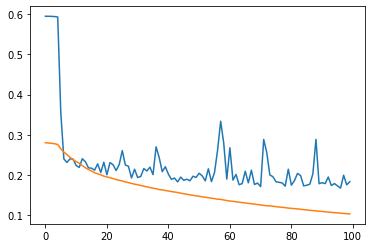

In [46]:
import pylab as pl
pl.plot(perceptron.train_errors, label='train')
pl.plot(perceptron.testing_errors, label='test')